In [1]:
# !pip install karateclub
# !pip install xgboost
# !pip install --upgrade jupyter
# !pip install --upgrade ipywidgets


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import networkx as nx
import pickle
from karateclub import DeepWalk
import torch
from torch_geometric.data import Data, DataLoader
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import xgboost as xgb
import matplotlib.pyplot as plt
import joblib
import os
from scipy.spatial.distance import cdist
from scipy.spatial.distance import euclidean
from joblib import Parallel, delayed
from tqdm import tqdm

In [3]:
# Load the data
data_path = 'stage3_data_cleaning/v2/type1_label_merged_final_decoded_clean3.xlsx'
df = pd.read_excel(data_path)

In [4]:
df.head()

,label,timestamp,can_id,data_length,source_node_id_decimal,service_flag,priority,message_type_decimal,destination_node_id_decimal,request_or_response,...,end_of_message,single_message_frame,transfer_ID,effective_data_0,effective_data_1,effective_data_2,effective_data_3,effective_data_4,effective_data_5,effective_data_6
0,0,0.000000,10015501,8,1,0,16,341,-99,-99,...,1,1,0,0,0,0,0,8,0,0
1,0,0.192053,104E2001,2,1,0,16,20000,-99,-99,...,1,1,0,0,-199,-199,-199,-199,-199,-199
2,0,0.192335,1F043901,8,1,0,31,1081,-99,-99,...,0,0,0,0,0,0,246,0,-199,-199
3,0,0.192504,1F043901,8,1,0,31,1081,-99,-99,...,0,0,0,0,248,0,0,247,255,223
4,0,0.192637,1F043901,4,1,0,31,1081,-99,-99,...,1,0,0,254,0,0,-199,-199,-199,-199


In [5]:
df.shape

(207858, 22)

In [9]:
whole_df = df
temp_df = df[df['timestamp']<60]

In [14]:
temp_df.nunique()

label                              2
timestamp                      42645
can_id                            38
data_length                        8
source_node_id_decimal             6
service_flag                       2
priority                           6
message_type_decimal               9
destination_node_id_decimal        6
request_or_response                3
service_type_id_decimal            2
start_of_message                   2
end_of_message                     2
single_message_frame               2
transfer_ID                       32
effective_data_0                 257
effective_data_1                 227
effective_data_2                 180
effective_data_3                 143
effective_data_4                 127
effective_data_5                 236
effective_data_6                  94
dtype: int64

In [27]:
df = temp_df

In [16]:
# Create a directory for saving shapelets and graphs
save_dir = 'saved_data_pickle/v1_segment_500_ts_less_60'
os.makedirs(save_dir, exist_ok=True)

# Save shapelets to disk
def save_shapelets(shapelets, filename):
    with open(os.path.join(save_dir, filename), 'wb') as f:
        pickle.dump(shapelets, f)

# Load shapelets from disk
def load_shapelets(filename):
    with open(os.path.join(save_dir, filename), 'rb') as f:
        return pickle.load(f)

# Save graph to disk
def save_graph(G, filename):
    nx.write_gpickle(G, os.path.join(save_dir, filename))

# Load graph from disk
def load_graph(filename):
    return nx.read_gpickle(os.path.join(save_dir, filename))

In [32]:

# Determine the split point
max_timestamp = df['timestamp'].max()
split_timestamp = 0.9 * max_timestamp

# Split the dataset
train_df = df[df['timestamp'] <= split_timestamp]
test_df = df[df['timestamp'] > split_timestamp]



In [33]:

# Paths for saving/loading shapelets and graphs
train_shapelets_file = 'type1_lab_clean3_train_shapelets_500.pkl'
test_shapelets_file = 'type1_lab_clean3_test_shapelets_500.pkl'
train_graph_file = 'type1_lab_clean3_train_graph_500.gpickle'
test_graph_file = 'type1_lab_clean3_test_graph_500.gpickle'

In [34]:
train_df=df

In [35]:
train_df.shape,test_df.shape


((42645, 22), (20472, 22))

In [25]:
train_df['label'].nunique(),test_df['label'].nunique()

(1, 2)

In [36]:
# df.nunique()

In [37]:
# train_df['label']

In [38]:
def extract_time_aware_shapelets(df, segment_length=500):
    shapelets = []
    labels = df['label'].unique()
    feature_columns = [col for col in df.columns if col not in ['label', 'timestamp', 'can_id']]
    scaler = MinMaxScaler()
    
    for label in tqdm(labels, desc='Extracting shapelets'):
        class_data = df[df['label'] == label]
        for i in range(0, len(class_data) - segment_length + 1):
            segment = class_data.iloc[i:i+segment_length]
            scaled_segment = scaler.fit_transform(segment[feature_columns])
            shapelets.append((scaled_segment.flatten(), label))
    
    return shapelets, feature_columns

In [ ]:
# shapelets, feature_columns = extract_time_aware_shapelets(df)
# train_shapelets, feature_columns = extract_time_aware_shapelets(train_df)
# test_shapelets, _ = extract_time_aware_shapelets(test_df)


# Extract shapelets or load from disk
if os.path.exists(os.path.join(save_dir, train_shapelets_file)):
    train_shapelets, train_feature_columns = load_shapelets(train_shapelets_file)
else:
    train_shapelets, train_feature_columns = extract_time_aware_shapelets(train_df, segment_length=200)
    save_shapelets((train_shapelets, train_feature_columns), train_shapelets_file)

In [ ]:
if os.path.exists(os.path.join(save_dir, test_shapelets_file)):
    test_shapelets, test_feature_columns = load_shapelets(test_shapelets_file)
else:
    test_shapelets, test_feature_columns = extract_time_aware_shapelets(test_df, segment_length=200)
    save_shapelets((test_shapelets, test_feature_columns), test_shapelets_file)

In [11]:
def visualize_shapelets(shapelets, num_shapelets=10):
    plt.figure(figsize=(15, 10))
    for i, (shapelet, label) in enumerate(shapelets[:num_shapelets]):
        plt.subplot(num_shapelets, 1, i + 1)
        plt.plot(shapelet)
        plt.title(f'Shapelet {i + 1} (Label: {label})')
        plt.tight_layout()
    plt.show()

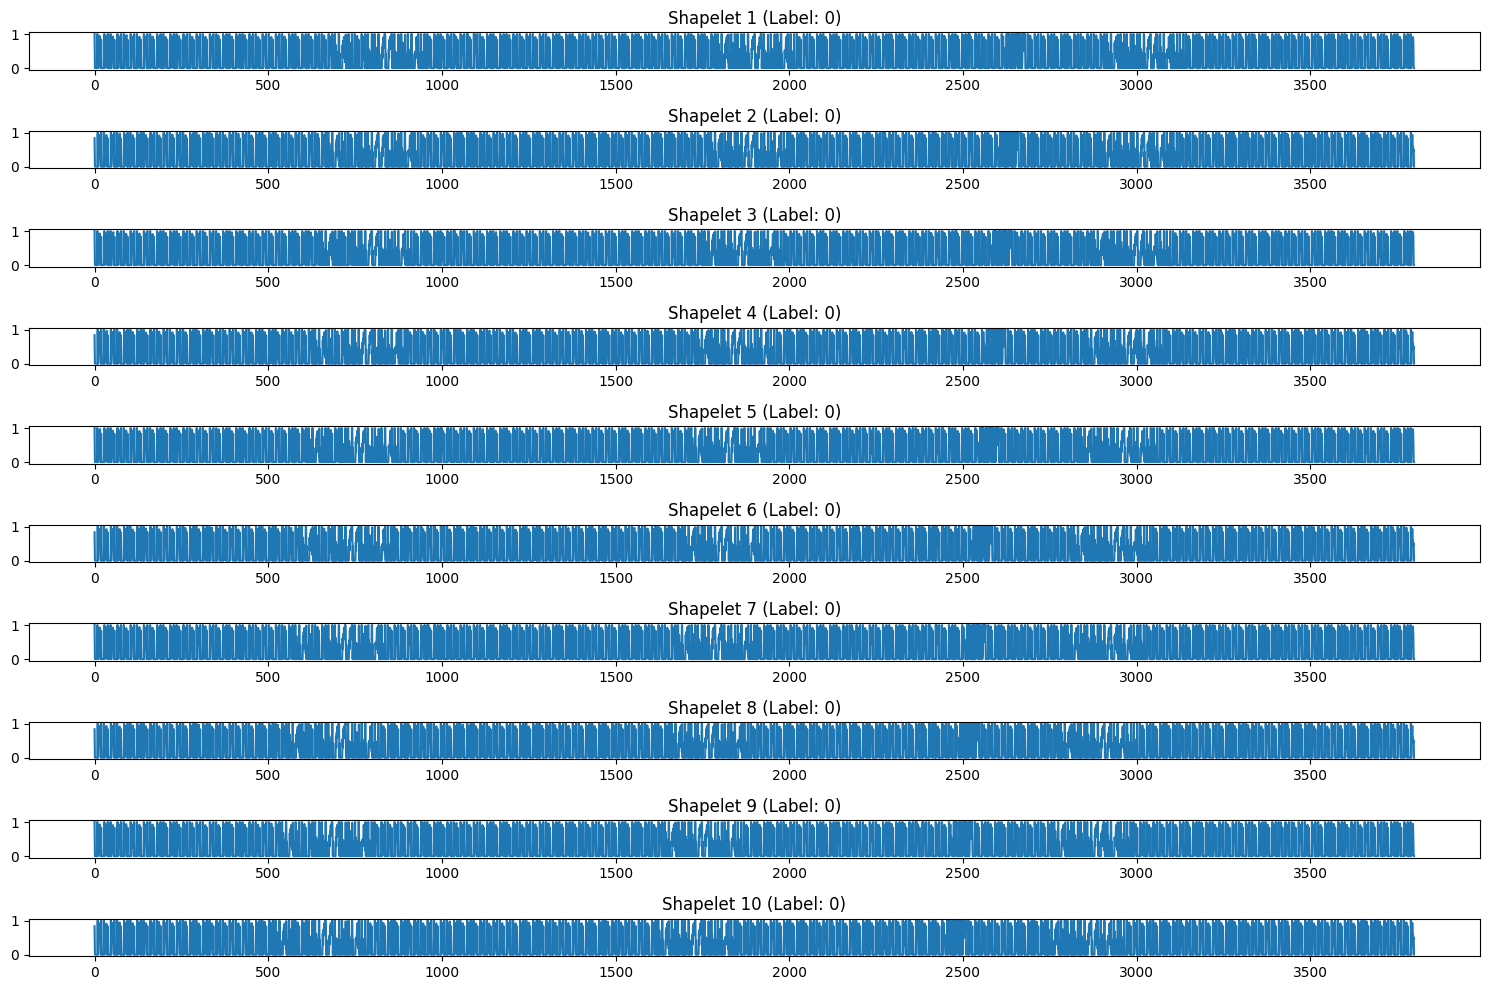

In [12]:
# Visualize the first 10 shapelets
visualize_shapelets(test_shapelets, num_shapelets=10)

In [13]:
len(train_shapelets)

140034

In [ ]:
# shapelets[0][0].shape[0]/24

In [ ]:
# len(shapelets[0]),shapelets[0]

In [14]:
def compute_edge(i, j, shapelet_vectors, distance_threshold):
    distance = euclidean(shapelet_vectors[i], shapelet_vectors[j])
    if distance < distance_threshold:
        return (i, j, distance)
    return None

def construct_shapelet_evolution_graph_incremental(shapelets, distance_threshold=0.1, n_jobs=-1):
    G = nx.DiGraph()
    shapelet_vectors = np.array([s[0] for s in shapelets])
    
    edges = Parallel(n_jobs=n_jobs)(delayed(compute_edge)(i, j, shapelet_vectors, distance_threshold) for i in tqdm(range(len(shapelets)), desc='Constructing edges') for j in range(i + 1, len(shapelets)))
    
    for edge in tqdm(edges, desc='Adding edges to graph'):
        if edge is not None:
            i, j, weight = edge
            G.add_edge(i, j, weight=weight)
    
    # Calculate PageRank
    pagerank = nx.pagerank(G, weight='weight')
    nx.set_node_attributes(G, pagerank, 'pagerank')
    
    return G

In [ ]:
# Construct the graph incrementally
# G = construct_shapelet_evolution_graph_incremental(shapelets)

In [ ]:
# Construct shapelet evolution graphs for training and testing sets
# train_G = construct_shapelet_evolution_graph_incremental(train_shapelets)
# test_G = construct_shapelet_evolution_graph_incremental(test_shapelets)


# Construct graphs or load from disk
if os.path.exists(os.path.join(save_dir, train_graph_file)):
    train_G = load_graph(train_graph_file)
else:
    train_G = construct_shapelet_evolution_graph_incremental(train_shapelets)
    save_graph(train_G, train_graph_file)

if os.path.exists(os.path.join(save_dir, test_graph_file)):
    test_G = load_graph(test_graph_file)
else:
    test_G = construct_shapelet_evolution_graph_incremental(test_shapelets)
    save_graph(test_G, test_graph_file)



Constructing edges:   8%|▊         | 11337/140034 [7:39:07<161:56:06,  4.53s/it]

In [ ]:
def visualize_shapelet_evolution_graph(G, title):
    pos = nx.spring_layout(G)
    pagerank = nx.get_node_attributes(G, 'pagerank')
    labels = {node: f'{node}\nPR: {pagerank[node]:.2f}' for node in G.nodes()}
    
    plt.figure(figsize=(15, 10))
    nx.draw(G, pos, with_labels=True, labels=labels, node_size=700, node_color='skyblue', font_size=10, edge_color='gray')
    plt.title(title)
    plt.show()

In [ ]:
# Visualize the shapelet evolution graphs
visualize_shapelet_evolution_graph(train_G, 'Shapelet Evolution Graph (Training)')
visualize_shapelet_evolution_graph(test_G, 'Shapelet Evolution Graph (Testing)')

In [ ]:
def construct_shapelet_evolution_graph_parallel(shapelets, distance_threshold=0.1, n_jobs=-1):
    G = nx.DiGraph()
    
    shapelet_vectors = np.array([s[0] for s in shapelets])
    distances = cdist(shapelet_vectors, shapelet_vectors, 'euclidean')
    
    def process_pair(i, j):
        if i != j and distances[i, j] < distance_threshold:
            return (i, j, distances[i, j])
        return None
    
    edges = Parallel(n_jobs=n_jobs)(delayed(process_pair)(i, j) for i in tqdm(range(len(shapelets)), desc='Constructing edges') for j in range(i + 1, len(shapelets)))
    
    for edge in tqdm(edges, desc='Adding edges to graph'):
        if edge is not None:
            i, j, weight = edge
            G.add_edge(i, j, weight=weight)
    
    # Calculate PageRank
    pagerank = nx.pagerank(G, weight='weight')
    nx.set_node_attributes(G, pagerank, 'pagerank')
    
    return G

# Example usage
G = construct_shapelet_evolution_graph_parallel(shapelets)


In [ ]:

def visualize_shapelet_evolution_graph(G):
    pos = nx.spring_layout(G)
    pagerank = nx.get_node_attributes(G, 'pagerank')
    labels = {node: f'{node}\nPR: {pagerank[node]:.2f}' for node in G.nodes()}
    
    plt.figure(figsize=(15, 10))
    nx.draw(G, pos, with_labels=True, labels=labels, node_size=700, node_color='skyblue', font_size=10, edge_color='gray')
    plt.title('Shapelet Evolution Graph')
    plt.show()

# Visualize the shapelet evolution graph
visualize_shapelet_evolution_graph(G)

In [ ]:
def learn_representations(G, embedding_size=128):
    model = DeepWalk(dimensions=embedding_size)
    model.fit(G)
    embeddings = model.get_embedding()
    
    # Add PageRank as an additional feature
    pagerank = nx.get_node_attributes(G, 'pagerank')
    pagerank_values = np.array([pagerank[node] for node in G.nodes()])
    
    # Combine embeddings with PageRank
    combined_embeddings = np.hstack((embeddings, pagerank_values.reshape(-1, 1)))
    
    return combined_embeddings

embeddings = learn_representations(G)

In [ ]:
def create_pyg_dataset(embeddings, shapelets, feature_columns):
    edge_index = torch.tensor([list(e) for e in G.edges()], dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor([G[u][v]['weight'] for u, v in G.edges()], dtype=torch.float)

    data_list = []
    for i, (embedding, (shapelet, label)) in tqdm(enumerate(zip(embeddings, shapelets)), desc='Creating PyG dataset'):
        x = torch.tensor(embedding, dtype=torch.float).unsqueeze(0)
        y = torch.tensor([label], dtype=torch.long)
        additional_features = torch.tensor(shapelet, dtype=torch.float).view(-1, len(feature_columns))
        x = torch.cat((x, additional_features), dim=1)
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
        data_list.append(data)
    
    return data_list

dataset = create_pyg_dataset(embeddings, shapelets, feature_columns)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [ ]:
# Create a directory for saving models
os.makedirs('models', exist_ok=True)

# Save function
def save_model(model, model_name):
    joblib.dump(model, f'models/{model_name}.joblib')

# Load function
def load_model(model_name):
    return joblib.load(f'models/{model_name}.joblib')
